#### Imports

In [1]:
from typing import Dict, List, Tuple, Optional
from collections import namedtuple

In [2]:
from functional import seq, pseq
from functional.streams import Sequence
from IPython.core.display import HTML

def display_seq(sequence:Sequence,rows:int)-> None:
        sequence._repr_html_= lambda :sequence.tabulate(rows,tablefmt='html')
        display(sequence)
        sequence._repr_html_= lambda :sequence.tabulate(10,tablefmt='html')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
import seaborn as sns
import igraph as ig

In [4]:
import os
import functools
def compose(*functions):
    def compose2(f, g):
        return lambda x: f(g(x))
    return functools.reduce(compose2, functions, lambda x: x)

#  Csv Processing

In [5]:
base_dir = "./eu/"
os.listdir(base_dir)

['email-Eu-core-department-labels.txt', 'email-Eu-core.txt', 'eu.csv']

In [6]:
with open(base_dir + 'email-Eu-core.txt') as f:
    edges = seq(f.readlines()).drop_while(lambda line : line[:1] == "#")\
    .map(lambda line: line.strip().split(" "))\
    .map(lambda strTup: (int(strTup[0]),int(strTup[1])))

In [7]:
ground_truth_communities = pd.read_csv(base_dir + "email-Eu-core-department-labels.txt",header=None,names=['node','community'], sep='\s+')

In [8]:
aggr = ground_truth_communities.groupby('community',as_index=False).count()

Text(0, 0.5, 'Community size')

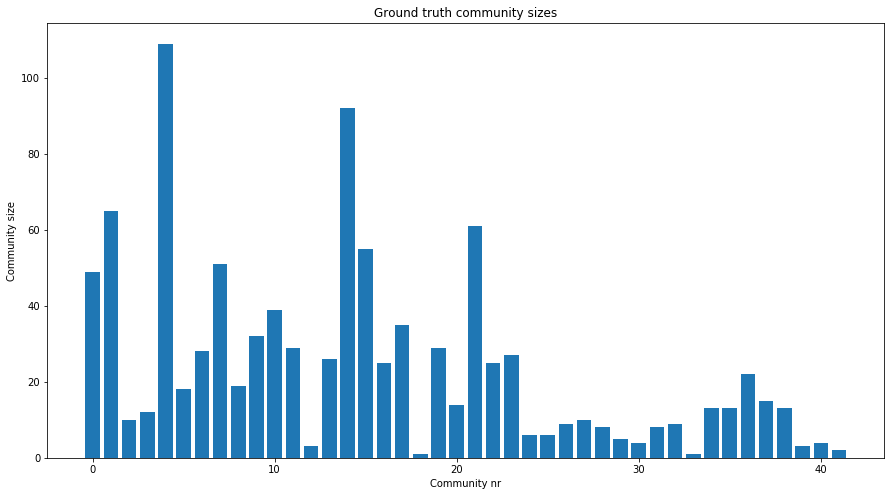

In [9]:
plt.bar(aggr.community,aggr.node)
plt.title("Ground truth community sizes")
plt.xlabel("Community nr")
plt.ylabel("Community size")

In [10]:
import igraph as ig

In [11]:
g = ig.Graph.TupleList(edges.to_list())

In [12]:
### Ground truth community modularity

In [13]:
g.modularity(ground_truth_communities.community)

0.31550491081535154

In [14]:
len(g.vs)

1005

In [22]:
im_communities = g.community_infomap()
lm_communities = g.community_multilevel()
lp_communities = g.community_label_propagation()
clusts = {
    "Ground truth": ground_truth_communities.community,
    "Infomap" : im_communities,
    "Multilevel":lm_communities,
    "Label propagation":lp_communities,
}

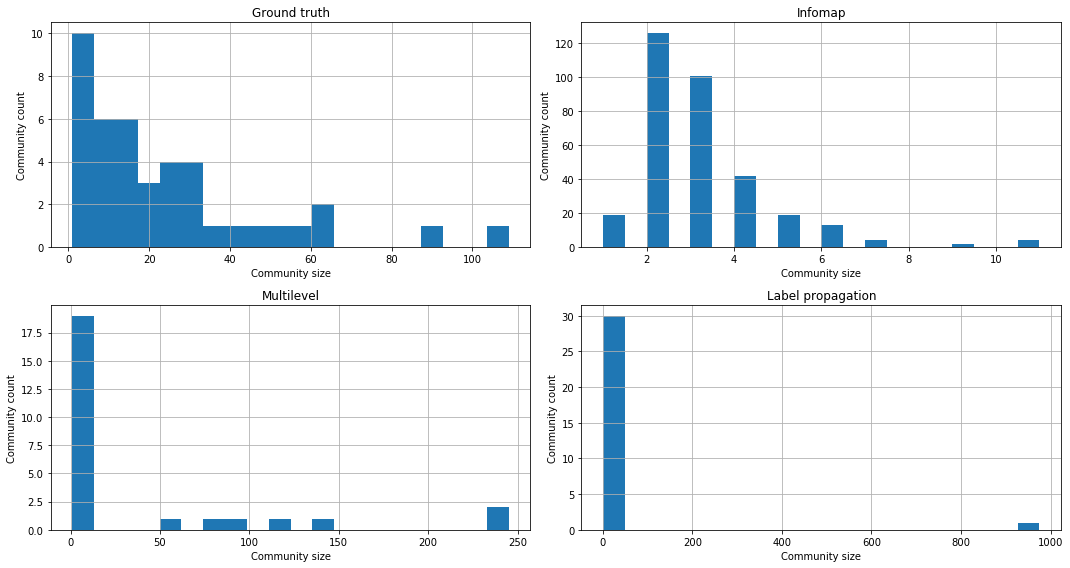

|Descriptior|Ground truth|Infomap|Multilevel|Label propagation|
|Modularity|0.32|0.06|0.44|0.0|
|Communities count|42|330|26|31|
|Community avg size|23.93|3.05|38.65|32.42|
|Community size std|24.22|1.59|72.93|174.94|
|Community max size|109.0|11.0|245.0|975.0|


In [23]:
descriptiors_ = ["Descriptior"]
modularity_ = ["Modularity"]
cnt_ = ["Communities count"]
avg_ = ["Community avg size"]
std_ = ["Community size std"]
max_ = ["Community max size"]

for i,kv in enumerate(clusts.items()):
    k,v = kv
    if type(v) == pd.Series:
        communities = seq(v)\
        .count_by_value().order_by(lambda x: -x[1])\
        .to_pandas(columns= ["community","size"])
    else:
        communities = seq(v.membership)\
        .count_by_value().order_by(lambda x: -x[1])\
        .to_pandas(columns= ["community","size"])
    
    plt.subplot(220 + 1 + i)
    plot = communities['size'].hist(bins= 20)
    plot.set_title(k)
    plot.set_xlabel("Community size")
    plot.set_ylabel("Community count")
    

    desc = communities['size'].describe()[["mean","std","max"]]
    descriptiors_.append(k)
    m = round(g.modularity(v),2)
    modularity_.append(m)
    cnt_.append(len(communities))
    avg = round(desc['mean'],2)
    avg_.append(avg)
    std = round(desc['std'],2)
    std_.append(std)
    _max = desc['max']
    max_.append(_max)


    
plt.tight_layout()
plt.show()
print("="* 10)
for l in [descriptiors_,modularity_,cnt_,avg_,std_,max_]:
    str_l = seq(l).map(str).to_list()
    print("|{}|".format("|".join(str_l)))

In [15]:
particles = pd.read_csv(base_dir + "eu.csv")
particles.head(n=1)

,id,community,alpha,beta
0,0,1,1.0,0.0


In [18]:
seq(particles.beta.drop_duplicates()).sorted()

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

In [19]:
desired_betas = [0.05, 0.1 , 0.2 , 0.3]

In [24]:
list(g.vs)[0]

igraph.Vertex(<igraph.Graph object at 0x7f37fa5d5e50>, 0, {'name': 0})

In [21]:
particles.where(particles.beta.isin(desired_betas))[['alpha','beta']].drop_duplicates().dropna()

,alpha,beta
3015,1.0,0.30
7035,1.0,0.10
8040,1.0,0.05
13065,1.0,0.20


In [27]:
descriptiors_ = ["Descriptior"]
modularity_ = ["Modularity"]
cnt_ = ["Communities count"]
avg_ = ["Community avg size"]
std_ = ["Community size std"]
max_ = ["Community max size"]

for beta in desired_betas:
    df = particles.where(particles.beta == beta).dropna()
    person_to_communiy = seq(df[['id','community']]).to_dict()
    membership = seq(list(g.vs)).map(lambda x: person_to_communiy[x['name']]).to_list()
    
    communities = seq(membership)\
    .count_by_value().order_by(lambda x: -x[1])\
    .to_pandas(columns= ["community","size"])
    
#     plot = communities['size'].hist(bins= 20)
#     plot.set_title(k)
#     plot.set_xlabel("Community size")
#     plot.set_ylabel("Community count")
#     plt.show()
    

    desc = communities['size'].describe()[["mean","std","max"]]
#     print("|Descriptor|{}|".format("Particles b={}".format(beta)) )
#     print("|Modularity |{}|".format(round(g.modularity(membership),2)))
#     print("|Communities count|{}|".format(len(communities)))
#     print("|Community avg size|{}|".format(desc['mean']))
#     print("|Community size std|{}|".format(round(desc['std']),2))
#     print("|Community max size|{}|".format(desc['max']))
    descriptiors_.append("PM b={}".format(beta)) 
    modularity_.append(round(g.modularity(membership),2))
    cnt_.append(len(communities))
    avg_.append(round(desc['mean'],2))
    std_.append(round(desc['std'],2))
    max_.append(desc['max'])
    
print("="* 10)
for l in [descriptiors_,modularity_,cnt_,avg_,std_,max_]:
    str_l = seq(l).map(str).to_list()
    print("|{}|".format("|".join(str_l)))

|Descriptior|PM b=0.05|PM b=0.1|PM b=0.2|PM b=0.3|
|Modularity|0.21|0.25|0.35|0.34|
|Communities count|21|16|53|62|
|Community avg size|47.86|62.81|18.96|16.21|
|Community size std|106.79|111.44|40.08|36.21|
|Community max size|484.0|422.0|216.0|188.0|


In [66]:
im_communities = g.community_infomap(edge_weights=g.edge_attributes()[0],trials = 30)

In [67]:
lm_communities = g.community_multilevel(weights=g.edge_attributes()[0])

In [68]:
lp_communities = g.community_label_propagation(weights=g.edge_attributes()[0])

In [88]:
clusts = {
    "Infomap" : im_communities,
    "Multilevel":lm_communities,
    "Label propagation":lp_communities
}

count     39.000000
mean      16.000000
std       43.757105
max      272.000000
Name: size, dtype: float64


For `modularity` we can use membership array in `g.modularity(arr)`
where `arr[i]` = community_nr of `list(g.vs)[i]`

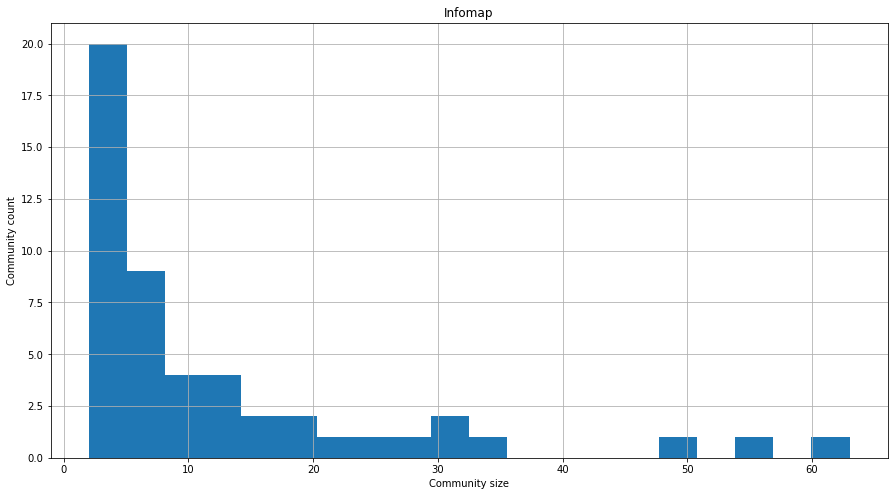

|Descriptor|Infomap|
|Modularity |0.55|
|Communities count|50|
|Community avg size|12.48|
|Community size std|14.0|
|Community max size|63.0|


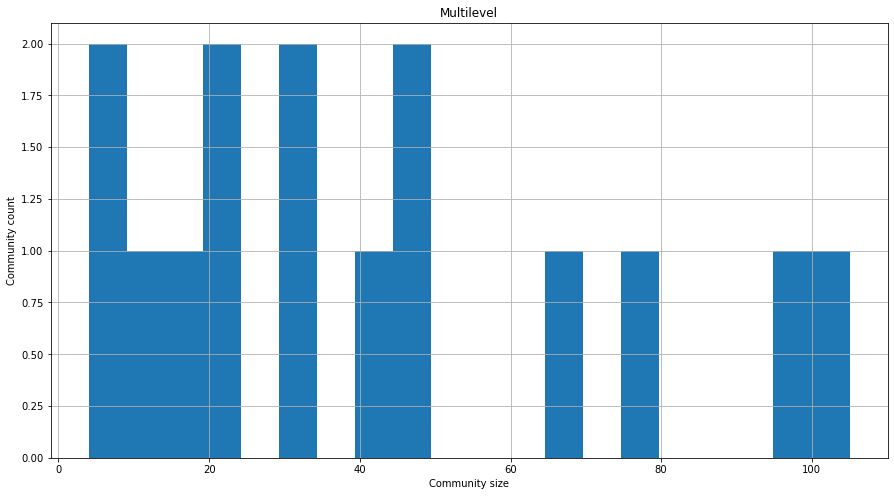

|Descriptor|Multilevel|
|Modularity |0.58|
|Communities count|15|
|Community avg size|41.6|
|Community size std|32.0|
|Community max size|105.0|


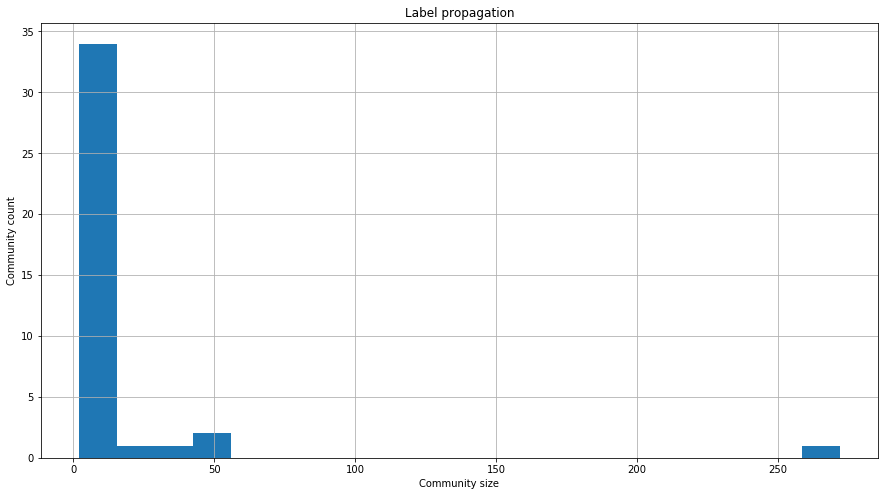

|Descriptor|Label propagation|
|Modularity |0.45|
|Communities count|39|
|Community avg size|16.0|
|Community size std|44.0|
|Community max size|272.0|


In [102]:
for k,v in clusts.items():
    communities = seq(v.membership)\
    .count_by_value().order_by(lambda x: -x[1])\
    .to_pandas(columns= ["community","size"])
    
    plot = communities['size'].hist(bins= 20)
    plot.set_title(k)
    plot.set_xlabel("Community size")
    plot.set_ylabel("Community count")
    plt.show()
    

    desc = communities['size'].describe()[["mean","std","max"]]
    print("|Descriptor|{}|".format(k) )
    print("|Modularity |{}|".format(round(g.modularity(v),2)))
    print("|Communities count|{}|".format(len(communities)))
    print("|Community avg size|{}|".format(desc['mean']))
    print("|Community size std|{}|".format(round(desc['std']),2))
    print("|Community max size|{}|".format(desc['max']))

0.5463515877988907

In [61]:
ig.plot(ddg)

IndexError: list index out of range

In [28]:
ig.compare_communities(im_communities,lm_communities)

1.14845664086854

3,166
0,54
4,54
2,46
8,34
18,30
20,22
12,16
16,13
17,12


### Local transitivity

In [12]:
trans_local = g.transitivity_local_undirected(mode="zero",weights ="weight")

In [13]:
len(trans_local) == len(g.vs)

True

In [14]:
df_trans_local = seq(list(g.vs)).map(lambda node:node['id']).zip(trans_local).to_pandas(columns= ['key','trans'])

In [15]:
def plot_trans(s:pd.Series,label:str,log:bool = True):
    plot = s.hist(bins=100)
    plot.set_xlabel(label)
    plot.set_ylabel("Node count")
    if log:
        plot.set_yscale('log')

In [16]:
list(df_trans_local.where(df_trans_local.trans > 1).dropna().key)

[]

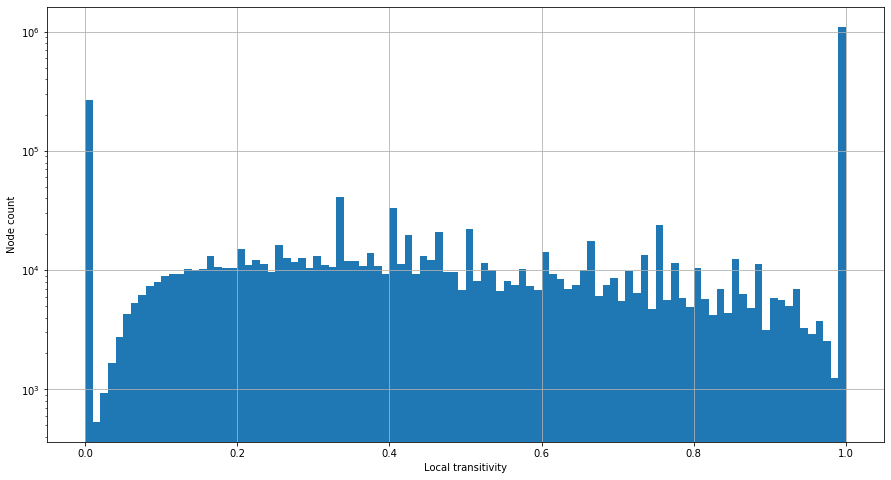

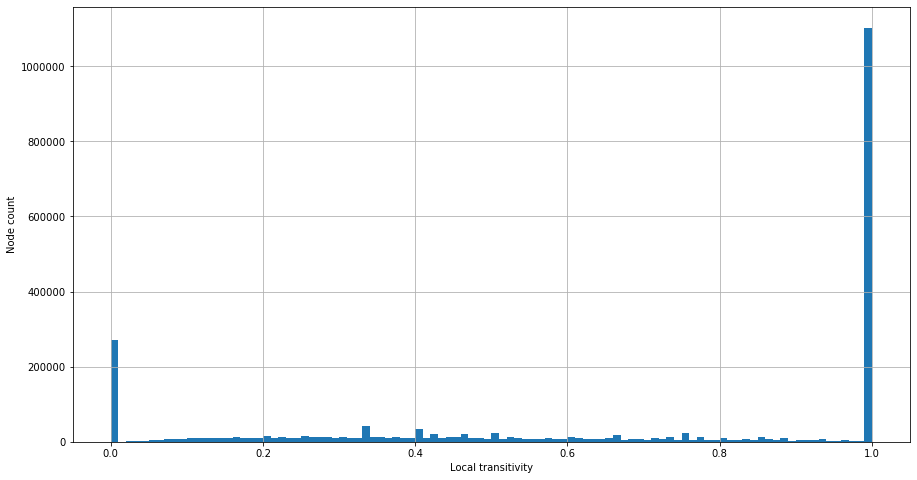

In [17]:
plot_trans(df_trans_local.trans, 'Local transitivity',log=True)
plt.show()
plot_trans(df_trans_local.trans, 'Local transitivity',log=False)

# Pagerank

In [18]:
keyset = seq(list(g.vs)).map(lambda x : x['id']).to_set()

In [38]:
"jeffrey d. ullman_pers" in keyset

True

In [19]:
pr = g.pagerank(directed=False,weights='weight')

In [20]:
df_pr= seq(list(g.vs)).map(lambda node:node['id']).zip(pr).to_pandas(columns= ['key','pr'])

In [21]:
top = df_pr.sort_values('pr',ascending=False).head(n=16)

In [23]:
persons = pd.read_csv(base_dir + "persons.csv").drop_duplicates(subset="key").dropna()
pers_dict = seq(persons).to_dict()
del persons

In [24]:
top['name'] = top.key.apply(lambda x: pers_dict[x])

In [25]:
print(top[['name','pr']].to_string(index=False))

            name        pr
        Wei Wang  0.000067
          Wei Li  0.000067
       Wei Zhang  0.000066
        Lei Wang  0.000059
       Lei Zhang  0.000056
        Yu Zhang  0.000056
        Jun Wang  0.000055
        Yang Liu  0.000054
         Jing Li  0.000054
        Xin Wang  0.000053
 H. Vincent Poor  0.000052
        Li Zhang  0.000050
       Jing Wang  0.000050
   Nadeem Javaid  0.000048
        Wei Chen  0.000048
    Nassir Navab  0.000048
